$\textbf{Selection of Depth and Areal Regions}$

$\text{In this tutorial we will see how to select the best region in the dataset using the PyCCAPT calibration module.}$

In [1]:
# Activate intractive functionality of matplotlib
%matplotlib ipympl
# import libraries
import os
import numpy as np
import sys
import logging
import os.path as path
import matplotlib.pyplot as plt
from ipywidgets import fixed, interact_manual, widgets

# Local module and scripts
from pyccapt.calibration.calibration_tools import variables, data_loadcrop, tools, data_tools
from pyccapt.calibration.calibration_tools import widgets as wd
from pyccapt.calibration.calibration_tools import dataset_path_qt
from pyccapt.calibration.mc import mc_tools
from pyccapt.calibration.leap_tools import ccapt_tools, leap_tools

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
 %reload_ext autoreload

In [4]:
# Disable showing logging in Jupyter notebook
logging.disable(sys.maxsize)

In [5]:
button = widgets.Button(
    description='load dataset',
)

@button.on_click
def open_file_on_click(b):
    global dataset_path
    dataset_path = dataset_path_qt.gui_fname().decode('ASCII')
button

Button(description='load dataset', style=ButtonStyle())

In [27]:
# check pytables library and install it
try:
    import tables
except:
    !conda install --yes --prefix {sys.prefix} pytables

In [28]:
tdc, pulse_mode, flightPathLength_d, t0_d, max_mc, det_diam = wd.dataset_tdc_selection()
display(tdc, pulse_mode, flightPathLength_d,  t0_d, max_mc)

Dropdown(description='Data mode:', options=('surface_concept', 'roentdec', 'leap_epos', 'leap_pos'), value='su…

Dropdown(description='Pulse mode:', options=('voltage', 'laser'), value='voltage')

FloatText(value=110.0, description='Flight path length:')

FloatText(value=54.0, description='t0:')

FloatText(value=400.0, description='Max mc:')

In [29]:
e = 1.6E-19  # coulombs per electron
amu = 1.66E-27  # conversion kg to Dalton
V = 1000 # minimum voltage
max_tof = np.sqrt(((max_mc.value * amu * (flightPathLength_d.value*1E-3) ** 2)) / (2 * e * V)) * 1E9 #in ns
print('The maximum possible TOF is:', max_tof, 'ns')

The maximum possible TOF is: 5010.738468529365 ns


$\text{Path to the dataset}$

In [30]:


dataset_main_path = os.path.dirname(dataset_path)
dataset_name_with_extention = os.path.basename(dataset_path)
dataset_name = os.path.splitext(dataset_name_with_extention)[0]

variables.init()

variables.result_path = dataset_main_path + '/' + dataset_name + '/load_crop/'
if not os.path.isdir(variables.result_path):
    os.makedirs(variables.result_path, mode=0o777, exist_ok=True)
    
print('The result will be saved on the path:', variables.result_path)
# dataset name
filename = dataset_path
savename = variables.result_path + '//' + dataset_name + '_cropped' + '.h5'

# Create data farame out of hdf5 file dataset
dld_group_storage = data_loadcrop.fetch_dataset_from_dld_grp(filename, tdc=tdc.value, pulse_mode=pulse_mode.value)

print('Total number of Ions:', len(dld_group_storage))

The result will be saved on the path: C:/Users/APTUser/Desktop/SS-420-1_data/load_crop/
Filename>> C:/Users/APTUser/Desktop/SS-420-1_data.h5
{'cropped_dld': ['high_voltage', 'pulse_voltage', 'start_counter', 't', 'x', 'y'], 'dld': ['high_voltage', 'pulse_voltage', 'start_counter', 't', 'x', 'y'], 'oxcart': ['high_voltage', 'main_chamber_vacuum', 'num_events', 'pulse_voltage', 'temperature', 'time_counter'], 'tdc': ['channel', 'high_voltage', 'pulse_voltage', 'start_counter', 'time_data'], 'time': ['time_h', 'time_m', 'time_s']}
Total number of Ions: 6767814


$\textbf {Crop and select the stable projection(right side) of below plotted graph}$
<br>
<br>
$\text{In the Experiment history plot below you should select the ions. After selectiong the ions with a rectangle you can continue and run the next cell. }$

In [31]:
dld_group_storage

,high_voltage (V),pulse (V),start_counter,t (ns),x_det (cm),y_det (cm)
0,511.000000,511.000000,31425.0,85.025484,-1.423102,0.996490
1,516.997009,516.997009,42846.0,3282.458256,-2.088490,-1.977061
2,519.994019,519.994019,23859.0,8123.170698,1.897469,1.684163
3,519.994019,519.994019,31756.0,1688.405310,2.330449,1.308490
4,521.990479,521.990479,14241.0,3585.328110,0.178286,2.470531
...,...,...,...,...,...,...
6767809,12000.616211,12000.616211,32451.0,2108.793852,0.553959,1.875184
6767810,12000.616211,12000.616211,32729.0,3197.377908,1.372163,1.633224
6767811,12000.616211,12000.616211,33236.0,13541.326740,-0.477551,-0.506204
6767812,12000.616211,12000.616211,33394.0,16423.949880,0.420245,3.581633


In [32]:
# Remove the data with tof biger thatn 5000 and lower than 0
mask_1 = (dld_group_storage['t (ns)'].to_numpy() > max_tof)
# mask_2 = (dld_group_storage['t (ns)'].to_numpy() < 0 )
# mask = np.logical_or(mask_1, mask_2)
print('The number of data over max_tof:', len(mask_1[mask_1==True]))
dld_group_storage.drop(np.where(mask_1)[0], inplace=True)
dld_group_storage.reset_index(inplace=True, drop=True)

The number of data over max_tof: 5793


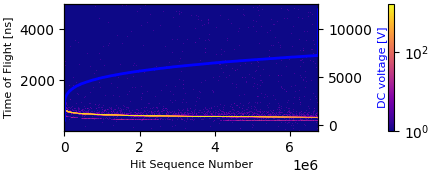

In [33]:
data_loadcrop.plot_crop_experimetn_history(dld_group_storage, save_name = variables.result_path + '//ex_hist_' + dataset_name)

$\text{Boundaries of the selected(cropped) part of the graph is printed below}$

In [34]:
# Crop the dataset
print('Min Idx:', variables.selected_x1, 'Max Idx:', variables.selected_x2)
data_crop = data_loadcrop.crop_dataset(dld_group_storage)

Min Idx: 366573.80025620107 Max Idx: 6567522.523086932


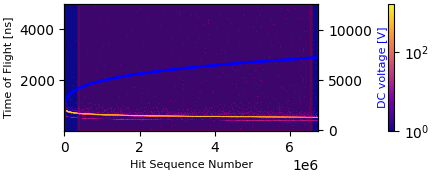

In [35]:
# Plot and selected experiment history
data_loadcrop.plot_crop_experimetn_history(dld_group_storage, rect=True, save_name=variables.result_path + '//ex_hist_slected_' + dataset_name)

$\textbf {ROI selcetion}$
<br>
<br>
$\text {Select the region of maximum concentration of electrons in the below plotted graph to utlize relevant data}$

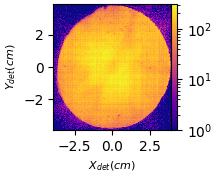

In [36]:
# Plot and select the FDM
data_loadcrop.plot_crop_FDM(data_crop,  bins=(256,256), save_name = variables.result_path + '//FDM_' + dataset_name)

$\text {The region selected in the previous step is displayed below.}$

x: -0.001345789861469271 y: -0.1469614126230403 roi: 3.578748804554385


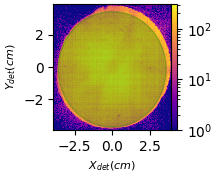

In [38]:
# plot selected area in FDM
data_loadcrop.plot_crop_FDM(data_crop, bins=(256,256), save_name = variables.result_path + '//FDM_c_' + dataset_name, circle=True)

$\text {The final selected data after processing is shown below.}$

d:\pyccapt\pyccapt\calibration\calibration_tools\data_loadcrop.py:243: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_crop.drop(np.where(mask_fdm)[0], inplace=True)


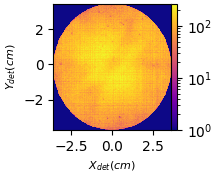

In [39]:
# Crop and plot the dataset
data_crop_FDM = data_loadcrop.crop_data_after_selection(data_crop)
data_loadcrop.plot_crop_FDM(data_crop_FDM, bins=(256,256), save_name = variables.result_path + '//FDM_crop_' + dataset_name, only_plot=True)

In [40]:
# calculate Pulses since last event pulse and Ions per pulse
counter = data_crop_FDM['start_counter'].to_numpy()

pulse_pi = np.zeros(len(counter))
ion_pp = np.zeros(len(counter))
temp = counter[0]
multi_hit_count = 1
pulse_to_previous_ion = 0
for i in range(len(counter)):

    if i+2 > len(counter):
        ion_pp[i] = multi_hit_count
        pulse_pi[i] = counter[i] - counter[i-1]
    else:
        if temp == counter[i+1]:
            multi_hit_count = multi_hit_count + 1
        else:
            if i != 0:
                temp = counter[i-1]
                pulse_to_previous_ion = counter[i] - temp
            else:
                pulse_to_previous_ion = 0
            for j in range(multi_hit_count):
                if j == 0:
                    ion_pp[i+j] = multi_hit_count
                    pulse_pi[i+j] = pulse_to_previous_ion
                elif j != 0 or i == 0:
                    ion_pp[i+j] = 0
                    pulse_pi[i+j] = 0
            multi_hit_count = 1


# add two calculated array to the croped dataset
data_crop_FDM['pulse_pi'] = pulse_pi.astype(np.uintc)
data_crop_FDM['ion_pp'] = ion_pp.astype(np.uintc)


C:\Users\APTUser\AppData\Local\Temp\ipykernel_21216\3416479450.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_crop_FDM['pulse_pi'] = pulse_pi.astype(np.uintc)
C:\Users\APTUser\AppData\Local\Temp\ipykernel_21216\3416479450.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_crop_FDM['ion_pp'] = ion_pp.astype(np.uintc)


$\text {The final dataset is saved and the percentage of loss in TOF croption is prited.}$

In [41]:
# save the cropped data

print('tof Crop Loss {:.2f} %'.format(((1 - len(data_crop_FDM) / len(dld_group_storage)) * 100)))

tof Crop Loss 14.31 %


In [42]:
# exctract needed data from Pandas data frame as an numpy array
dld_highVoltage = data_crop_FDM['high_voltage (V)'].to_numpy()
if pulse_mode.value == 'voltage':
    dld_pulseVoltage = data_crop_FDM['pulse (V)'].to_numpy()
elif pulse_mode.value == 'laser':
    dld_pulseVoltage = data_crop_FDM['pulse (deg)'].to_numpy()
dld_t = data_crop_FDM['t (ns)'].to_numpy()
dld_x = data_crop_FDM['x_det (cm)'].to_numpy()
dld_y = data_crop_FDM['y_det (cm)'].to_numpy()

mc_seb_ini = mc_tools.tof2mc(dld_t, t0_d.value, dld_highVoltage, dld_pulseVoltage, dld_x, dld_y, flightPathLength_d.value, mode=pulse_mode.value)

data_crop_FDM.insert(0, 'x (nm)', np.zeros(len(mc_seb_ini)))
data_crop_FDM.insert(1, 'y (nm)', np.zeros(len(mc_seb_ini)))
data_crop_FDM.insert(2,'z (nm)', np.zeros(len(mc_seb_ini)))

data_crop_FDM.insert(3,'mc_c (Da)', np.zeros(len(mc_seb_ini)))
data_crop_FDM.insert(4, 'mc (Da)', mc_seb_ini)

data_crop_FDM.insert(9,'t_c (ns)', np.zeros(len(mc_seb_ini)))

In [43]:
# Remove the data with mc biger thatn 400
mask = (data_crop_FDM['mc (Da)'].to_numpy() > max_mc.value)
print('The number of data over max_mc:', len(mask[mask==True]))
data_crop_FDM.drop(np.where(mask)[0], inplace=True)
data_crop_FDM.reset_index(inplace=True, drop=True)

The number of data over max_mc: 72368


C:\Users\APTUser\AppData\Local\Temp\ipykernel_21216\2594199460.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_crop_FDM.drop(np.where(mask)[0], inplace=True)


The peak index for MRP calculation is: 1


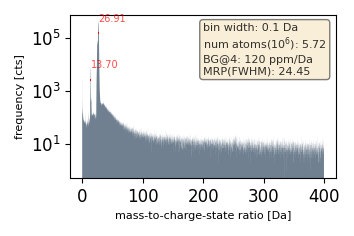

Mass resolving power for the highest peak (MRP --> m/m_2-m_1): 24.454545497333505
Peaks  0 is at location and height: (13.70, 7584.00) peak window sides (50.00%) are: (13.40, 13.90)
Peaks  1 is at location and height: (26.91, 388444.00) peak window sides (50.00%) are: (26.41, 27.51)


In [44]:
percent_mrp = 50
# background = {'calculation': True, 'plot_no_back': True, 'plot': True, 'mode': 'fabc', 'patch': False, 'lam': 1e4, 'num_std': 10.0}
background = {'calculation': False}
# non_peaks = np.array([[2,10], [18,10], [26, 10], [200, 10], [300, 10], [400, 10]])
# background = {'calculation': True, 'plot_no_back': False, 'plot': True, 'mode': 'selective_mask_mc', 'patch': False, 'lam': 1e4, 'num_std': 7.0, 'non_mask': non_peaks}


peaks_ini, peaks_y_ini, peak_widths_p_ini = tools.hist_plot(data_crop_FDM['mc (Da)'], 0.1, prominence=200, distance=100, h_line=True, text_loc='right', percent=percent_mrp, plot=True, label='mc', fig_name='mc', background=background)
index_max_ini = np.argmax(peaks_y_ini)
mrp = (peaks_ini[index_max_ini] / (peak_widths_p_ini[index_max_ini][2] - peak_widths_p_ini[index_max_ini][1]))
print('Mass resolving power for the highest peak (MRP --> m/m_2-m_1):', mrp)
for i in range(len(peaks_ini)):
    print('Peaks ', i, 'is at location and height: ({:.2f}, {:.2f})'.format(peaks_ini[i], peaks_y_ini[i]), 'peak window sides ({:.2f}%) are: ({:.2f}, {:.2f})'.format(percent_mrp, peak_widths_p_ini[i][1], peak_widths_p_ini[i][2]))
    

In [45]:
# Remove the data with x,y,t = 0
mask1 = (data_crop_FDM['x (nm)'].to_numpy() == 0)
mask2 = (data_crop_FDM['y (nm)'].to_numpy() == 0)
mask3 = (data_crop_FDM['t (ns)'].to_numpy() == 0)
mask = np.logical_and(mask1, mask2)
mask = np.logical_and(mask, mask3)
print('The number of data over max_mc:', len(mask[mask==True]))
data_crop_FDM.drop(np.where(mask)[0], inplace=True)
data_crop_FDM.reset_index(inplace=True, drop=True)

The number of data over max_mc: 0


C:\Users\APTUser\AppData\Local\Temp\ipykernel_21216\2640384541.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_crop_FDM.drop(np.where(mask)[0], inplace=True)


In [46]:
data_crop_FDM

,x (nm),y (nm),z (nm),mc_c (Da),mc (Da),high_voltage (V),pulse (V),start_counter,t (ns),t_c (ns),x_det (cm),y_det (cm),pulse_pi,ion_pp
0,0.0,0.0,0.0,0.0,27.148657,4143.929199,4143.929199,42352.0,708.431400,0.0,-1.111102,1.945224,0,1
1,0.0,0.0,0.0,0.0,26.885558,4143.929199,4143.929199,42684.0,715.399128,0.0,2.906694,0.725878,332,1
2,0.0,0.0,0.0,0.0,26.481908,4143.929199,4143.929199,42685.0,709.782426,0.0,2.884408,0.636735,1,1
3,0.0,0.0,0.0,0.0,27.026027,4143.929199,4143.929199,42747.0,705.022974,0.0,-1.897469,0.821388,62,1
4,0.0,0.0,0.0,0.0,27.079563,4143.929199,4143.929199,42749.0,706.860918,0.0,-1.929306,1.006041,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5721933,0.0,0.0,0.0,0.0,27.765140,7204.693359,7204.693359,36048.0,546.939216,0.0,0.738612,-0.038204,10,1
5721934,0.0,0.0,0.0,0.0,27.338082,7204.693359,7204.693359,36069.0,543.709098,0.0,0.881878,0.235592,21,1
5721935,0.0,0.0,0.0,0.0,26.737142,7204.693359,7204.693359,36427.0,538.908498,0.0,1.066531,-0.060490,358,1
5721936,0.0,0.0,0.0,0.0,25.845071,7204.693359,7204.693359,36494.0,530.809200,0.0,-1.056980,-0.232408,67,1


In [47]:
data_crop_FDM.dtypes

x (nm)              float64
y (nm)              float64
z (nm)              float64
mc_c (Da)           float64
mc (Da)             float64
high_voltage (V)    float64
pulse (V)           float64
start_counter       float64
t (ns)              float64
t_c (ns)            float64
x_det (cm)          float64
y_det (cm)          float64
pulse_pi             uint32
ion_pp               uint32
dtype: object

In [48]:
# save the dataset to hdf5 file
hierarchyName = 'df'
data_tools.store_df_to_hdf(savename, data_crop_FDM, hierarchyName)

In [131]:
# save data as epos file
epos = ccapt_tools.ccapt_to_epos(data_crop_FDM, path=variables.result_path, name=dataset_name + '.epos')
pos = ccapt_tools.ccapt_to_pos(data_crop_FDM, path=variables.result_path, name=dataset_name + '.pos')

In [ ]:
# save data in csv format
data_tools.store_df_to_csv(data_crop_FDM, variables.result_path + dataset_name + '.csv')